#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
taxi.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [7]:
taxi_h = taxi.resample('1H').sum()

В ходе первичного анализа можно отметить, что данные предоставлены с 1 марта 2018 года до 31 августа 2018 за каждые 10 минут. Укрупнили разбег времени в 1 час. 

## Анализ

In [8]:
taxi_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
taxi_h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
taxi_h.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


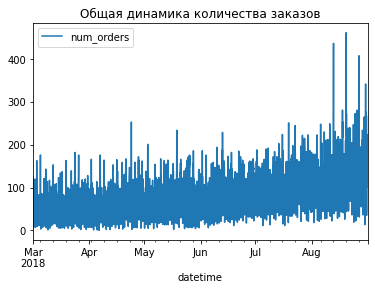

In [11]:
taxi_h.plot()
plt.title('Общая динамика количества заказов');

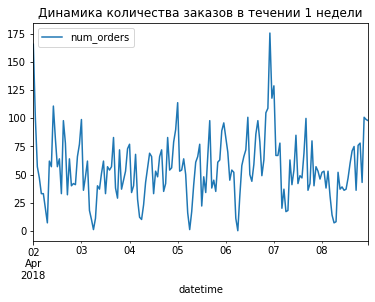

In [12]:
taxi_h['2018-04-02':'2018-04-08'].plot()
plt.title('Динамика количества заказов в течении 1 недели');

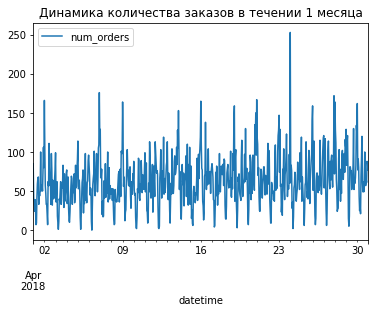

In [13]:
taxi_h['2018-04-01':'2018-04-30'].plot()
plt.title('Динамика количества заказов в течении 1 месяца');

В ходе первичного анализа можно отметить, что данные предоставлены с 1 марта 2018 года до 31 августа 2018 за каждые 10 минут. Укрупнили разбег времени в 1 час.
В ходе первичного анализа можно сделать следующие выводы:
1.	При укрупнении данных в итоге предоставили данные о заказах такси за 4416 часов
2.	По графику видно, что количество заказов в августе сравнительно больше, отмечается корреляция по дням недели, дням, часам.
3.	Среднее число заказов в час составляет 84.
4.	Максимальное количество заказов 462.
Для дальнейшего предсказания  можно отметить, что наибольшим влиянием оказывает месяц и день недели.


In [14]:
decomposed = seasonal_decompose(taxi_h)

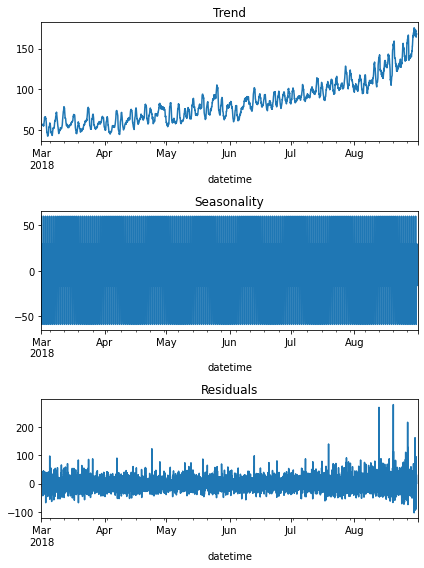

In [15]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot() 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot() 
plt.title('Residuals')
plt.tight_layout()

Отмечается восходящий тренд начиная с мая. При анализе остатков отмечаются выпадающие значения в августе, эти данные приходятся на тестовую выборку, что может привести к сниженю качества модели на тестовой выборке. Сезонность можно оценить только при укрупнении данных. 

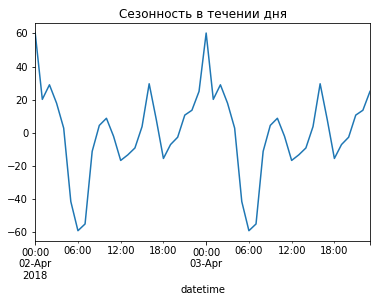

In [16]:
decomposed.seasonal['2018-04-02':'2018-04-03'].plot()
plt.title('Сезонность в течении дня');

в ходе изучения количества заказов по часам можно отметить: 
    
1. с 00.00 до 6.00 количество заказов уменьшается
    
2. Количество заказов значительно увеличивается с 6.00 до 11.00 (многие предпочитают такси, чтобы добраться до работы)
    
3. С 12.00 до 16.00 количество заказов падает
    
4. с 17.00 до 24.00  количество заказов значительно увеличивается


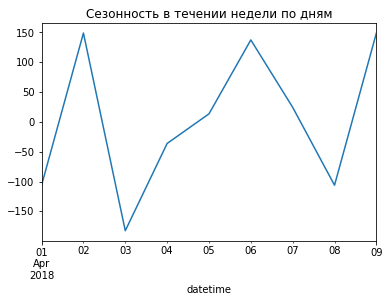

In [17]:
taxi_d = taxi.resample('1D').sum()
decomposed_d = seasonal_decompose(taxi_d)
decomposed_d.seasonal['2018-04-01':'2018-04-09'].plot()
plt.title('Сезонность в течении недели по дням');

в ходе изучения количества заказов по дням недели можно отметить: 
    
1. в пн (02.04) идет увеличение числа заказов
    
2. ВТ значительное снижение числа заказов
    
3. С чт по пт увеличение числа заказов
    
4. в выходные число заказов снижается


In [18]:
def make_features(df, max_lag, rolling_mean_size):
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df = df.dropna()

In [19]:
make_features(taxi_h, 50, 5)

In [20]:
train, test = train_test_split(taxi_h, shuffle=False, test_size=0.1)

In [21]:
train = train.dropna()
target_train = train['num_orders']
target_test = test['num_orders']

In [22]:
train = train.drop(columns = 'num_orders')
test = test.drop(columns = 'num_orders')

## Обучение

In [23]:
a = {'n_jobs':[-1, None]}
tscv = TimeSeriesSplit(n_splits=10)
LR = GridSearchCV(estimator = LinearRegression(), cv=tscv, param_grid =a,  verbose=False, scoring='neg_mean_squared_error')
LR.fit(train, target_train)
pred_train_LR = LR.predict(train)
RMSE_LR = mean_squared_error(target_train, pred_train_LR) ** 0.5
RMSE_LR

23.432796560781412

In [24]:
params_cat = {'iterations': [100], 'depth':[10, 12]}
#cat = GridSearchCV(estimator = CatBoostRegressor(), param_grid = params_cat, cv=tscv, verbose=False, scoring='neg_mean_squared_error')
#cat.fit(train, target_train)

#cat.best_params_

In [25]:
cat = CatBoostRegressor(iterations = 100, depth = 10,  verbose=False)
cat.fit(train, target_train)
pred_train_CB = cat.predict(train)
RMSE_CB = mean_squared_error(target_train, pred_train_CB) ** 0.5
RMSE_CB

5.233151534851547

In [26]:
params_RFR = {'n_estimators': [50, 70, 100], 'max_depth': [5, 10]}

#RFR = GridSearchCV(estimator = RandomForestRegressor(), param_grid = params_RFR, cv=tscv, n_jobs=-1, verbose=1)
#RFR.fit(train, target_train)
#RFR.best_params_

In [27]:
RFR = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=10)
RFR.fit(train, target_train)
pred_train_RFR = RFR.predict(train)
RMSE_RFR = mean_squared_error(target_train, pred_train_RFR) ** 0.5
RMSE_RFR

13.291032669865661

In [28]:
summ = pd.DataFrame(
    {'RMSE': [RMSE_CB, RMSE_LR, RMSE_RFR]},
     index = ['CatBoost', 'LR', 'RFR'])
summ

,RMSE
CatBoost,5.233152
LR,23.432797
RFR,13.291033


В ходе подбора гиперпараметров были протестированы следующме модели:
1. Линейная регрессия RMSE = 23
2. Случайный лес (random_state=12345, n_estimators=100, max_depth=10) RMSE = 13
3. CatBoost (iterations = 100, depth = 12) RMSE = 5

Наилучшая модель для прогноза:  
CB = CatBoostRegressor(iterations = 100, depth = 10,  verbose=False)

## Тестирование

In [29]:
pred_test_CB = cat.predict(test)
RMSE_CB = mean_squared_error(target_test, pred_test_CB) ** 0.5
RMSE_CB

45.63644159406504

Результат метрики RMSE на тестовой выборке удовлетворительный. 
Подобраная модель: CatBoostRegressor(iterations = 100, depth = 10,  verbose=False) прошла тестирование. 

### Проверка модели на адекватность

In [30]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
RMSE_previous = mean_squared_error(target_test, pred_previous) ** 0.5
RMSE_previous

58.856486242815066

В сравнении с моделью, которая предсказывает значение по предыдущему, у выбранной модели прогноза результат значительно лучше

### Общий вывод:

В ходе первичного анализа можно отметить, что данные предоставлены с 1 марта 2018 года до 31 августа 2018 за каждые 10 минут. Укрупнили разбег времени в 1 час.
В ходе первичного анализа можно сделать следующие выводы:

1.	При укрупнении данных в итоге предоставили данные о заказах такси за 4416 часов
2.	По графику видно, что количество заказов в августе сравнительно больше, отмечается корреляция по дням недели, дням, часам.
3.	Среднее число заказов в час составляет 84.
4.	Максимальное количество заказов 462.


в ходе изучения количества заказов по часам можно отметить: 
1. с 00.00 до 6.00 количество заказов уменьшается
2. Количество заказов значительно увеличивается с 6.00 до 11.00 (многие предпочитают такси, чтобы добраться до работы)
3. С 12.00 до 16.00 количество заказов падает
4. с 17.00 до 24.00  количество заказов значительно увеличивается


в ходе изучения количества заказов по дням недели можно отметить: 
1. в пн (02.04) идет увеличение числа заказов
2. ВТ значительное снижение числа заказов
3. С чт по пт увеличение числа заказов
4. в выходные число заказов снижается

В ходе подбора гиперпараметров были протестированы следующие модели:\
1. Линейная регрессия RMSE = 23
2. Случайный лес (random_state=12345, n_estimators=100, max_depth=10) RMSE = 13
3. CatBoost (iterations = 100, depth = 12) RMSE = 5


Наилучшая модель для прогноза:  
CB = CatBoostRegressor(iterations = 100, depth = 10,  verbose=False)

Результат метрики RMSE на тестовой выборке удовлетворительный(45). 
Подобраная модель: CatBoostRegressor(iterations = 100, depth = 10, verbose=False) прошла тестирование.

Произведена проверка модели на адекватность. У выбранной модели результат лучше, чем у модели, которая предсказывает предыдущее значение. 